# Machine Learning Programming Exercise 6: <ins>Supervised classification</ins>


## Objectifs


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:
<img src="imgs/screenshot001.png" />


L'objectif est d'écrire des scripts permettant de mettre en \oe uvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des pixels
* évaluation du classifieur appris

<img src="imgs/screenshot002.png" />

Le TP est globalement organisé de la manière suivante
* **Données**
 1. tout d'abord apprendre les modèles de classement (classifieurs) sur les données brutes (descripteurs=features=valeurs des pixels) 
 2. puis dans un second temps sur des descripteurs extraits à partir d'un algorithme appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à une banque de filtres mise en cascade). 

* **Prétraitements** Aucun prétraitement ne sera réalisé. 

* **Ensembles de données**
 1. Les ensembles de données seront composés de 1/3 de la base totale d'images. 
 2. Dans un second temps, nous procéderons par [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html) car la base d'images est de taille réduite.
* **Algorithmes** 
    Concernant les algorithmes supervisés de machine learning, l'objectif est d'utiliser les deux algorithmes de regression logistique et de réseaux de neurones que vous avez développés aux TP précédents et de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

* Pour commencer avec cette séance, vous aurez besoin de **télécharger** le _starter code_  disponible sur le lien Moodle du cours.

<span style='color:red'>**Dans cet exercice, il vous est demandé de fournir un rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un pdf ou d'un jupyter notebook. Il est de plus conseillé de faire tourner les codes sur google colab si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire).**</span>


## Fichiers inclus dans le starter code pour cette séance
* **pythonTools.py** - fonctions utiles pour l'affichage, le chargement des données et l'évaluation des performances
* **usefulCmds.py** - quelques commandes pour faciliter l'import des patchs
* **dataSet** - répertoire avec les images et les labels correspondants
* **dataSet\imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat** - fichier matlab contenant les descripteurs extraits des images par le scattering operator



# Part 0: intro

## 0.1 imports

_Your commented code below_

In [2]:
from pythonTools import *
from usefulCmds import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



None


## 0.2 Examen des données

Écrire des lignes de code permettant:
* de charger les données comprises dans le fichier _labels.csv_,
* de mettre en matrice les descripteurs de l'ensemble de la base d'images
* d'afficher les images avec la fonction _plot\_batch()_ du fichier \_pythonTools.py_,


_Your commented code below_

In [3]:
# Charger le fichier CSV
DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)


print("----------------------------------------Data information--------------------------------------------")
#print nombre de données
print("Dimensions du dataset:",dataset_df.shape)

#Nombre de classes:
print(pd.unique(dataset_df['seafloor']).tolist())
#Nombre d'images par classes
print(dataset_df.groupby('seafloor').nunique())

#Ploting batch
print("----------------------------------------Batch--------------------------------------------")
#getting 5 random data
batch=load_batch(dataset_df,5)
print(batch)

----------------------------------------Data information--------------------------------------------
Dimensions du dataset: (360, 2)
['Posidonia', 'Ripple 45°', 'Rock', 'Sand', 'Silt', 'Ripple vertical']
                 id  seafloor
seafloor                     
Posidonia        60         1
Ripple 45°       60         1
Ripple vertical  60         1
Rock             60         1
Sand             60         1
Silt             60         1
----------------------------------------Batch--------------------------------------------
                            id    seafloor
115  Ripple 45°_Sure.00125.png  Ripple 45°
47    Posidonia_Sure.00146.png   Posidonia
66   Ripple 45°_Sure.00018.png  Ripple 45°
191        Sand_Sure.00041.png        Sand
63   Ripple 45°_Sure.00013.png  Ripple 45°


**Question: Quels sont le nombre de données et le nombre de descripteurs?**

Il y a 360 données. C'est données sont réparties en 6 classes. 
Il y a 60 images par classes.

Il y a 40000 descipteurs par images.(voir plus bas)

Posidonia        60         
Ripple 45°       60         
Ripple vertical  60         
Rock             60     
Sand             60       
Silt             60         

In [4]:
# We add another column to the labels dataset to identify image path
dataset_df['image_path'] = dataset_df.apply( lambda row: (DATASET_PATH + row["id"] ), axis=1)

# Chargement des images
feature_values = np.array([plt.imread(img).reshape(40000,) for img in dataset_df['image_path'].values.tolist()])


## 0.3 prétraitements des labels

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de disposer des labels dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms, indices, one-hot-encoding, etc.) 


_Your commented code below_

In [89]:

# Récupération des labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique()

#  transformation des labels selon différents codages
# indices
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names_unique)

# one-hot-encoding
label_ohe = pd.get_dummies(label_names.reset_index(drop=True)).values

# Getting labels for our dataset
y = le.transform(label_names)
#y = to_categorical(y)


## 0.4 Séparation des données en ensembles 

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de [normaliser](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin 
* de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) un pour l'apprentissage et un pour le test


_Your commented code below_

In [90]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(feature_values, y, test_size = 0.25, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(270, 40000) (270,) (90, 40000) (90,)


<strong>Question:</strong> Pour <ins>chaque ensemble de données</ins> et <ins>pour chaque classe</ins>, quels sont le nombre de données et le nombre de descripteurs? Est-ce important? Pourquoi?

Il y a 75 pourcents des données dans Xtrain et 25 pourcents des données dans Xtest.

X_train= 270 examples

X_test= 90 examples

Pour chaques images il y a 40000 descripteurs (200*200)


_Your commented code below_

In [91]:
#Lets create a validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_val.shape, y_val.shape)


# Part 1 approches supervisées sur données brutes

<strong><ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?</strong> 

Il est necessaire de normaliser les descripteurs. En effet de cette façon le modèle converge plus rapidement.On associe à chaque descripteurs la même importance dans la prédiction.

In [92]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

**<ins>Question</ins>: Nous allons apprendre les modèles suivants:
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones (solver=lbfgs), svm et random forest en utilisant les fonctions du package scikit-learn

Faire la liste des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment fixe-t-on leurs valeurs?**

# Pour la regression logistique regularisée les hyper-paramètres du modèle sont :

-le taux d'apprendtissage

-le paramètre de régularisation

# Pour le réseau de neurones:

-le taux d'apprentissage

-le nombre d'hidden layer

# Pour le random forest:

-la pronfondeur des arbres

-le nombre d'arbres dans la forêt

<strong><ins>Question</ins>: Fixez au mieux les valeurs des hyperparamètres, réalisez l'apprentissage des modèles suivants: 
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

_Your code below_

In [93]:
#-------------------REGRESSION LOGISTIQUE REGULARISEE---------------------
from linearRegCostFunction import linearRegCostFunction
from trainLinearReg import trainLinearReg
from learningCurve import learningCurve
from polyFeatures import polyFeatures
from featureNormalize import featureNormalize
from plotFit import plotFit
from validationCurve import validationCurve
#-------------------NEURAL NETWORK-----

In [94]:
#-------------------NEURAL NETWORK WITH SCIKIT LEARN AND TENSORFLOW---------------------
# Importing libraries
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#Fonction de construction du CNN
def build_classifier(optimizer='adam'):
    # Initialising the CNN
    classifier = Sequential()

    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu',input_dim = 40000))
    classifier.add(Dense(units = 128, activation = 'relu'))
    #classifier.add(Dense(units = 128, activation = 'relu'))

    classifier.add(Dense(units = 6, activation = 'softmax'))

    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

#Instance du classifier
classifier = KerasClassifier(build_fn = build_classifier)

#Liste de paramétres à tester lors de l'entraînement.
parameters = {'batch_size': [50],
              'epochs': [150],
              'optimizer': ['adam']}
#Création de la grille d'entraînement.
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5)
#On entraîne avec les différents paramètres spécipfiés dans la liste.
grid_search = grid_search.fit(X_train, y_train)
#On évalue le score et les meilleurs paramétres
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_accuracy,best_parameters)
score = grid_search.score(X_test, y_test)
print(score)

Epoch 1/150
5/5 [==============================] - 0s 7ms/step - loss: 14.5968 - accuracy: 0.2361
Epoch 2/150
5/5 [==============================] - 0s 7ms/step - loss: 5.9842 - accuracy: 0.5000
Epoch 3/150
5/5 [==============================] - 0s 7ms/step - loss: 3.6994 - accuracy: 0.6111
Epoch 4/150
5/5 [==============================] - 0s 8ms/step - loss: 4.0622 - accuracy: 0.6296
Epoch 5/150
5/5 [==============================] - 0s 9ms/step - loss: 2.0589 - accuracy: 0.8102
Epoch 6/150
5/5 [==============================] - 0s 8ms/step - loss: 2.1686 - accuracy: 0.8380
Epoch 7/150
5/5 [==============================] - 0s 7ms/step - loss: 0.6495 - accuracy: 0.8889
Epoch 8/150
5/5 [==============================] - 0s 8ms/step - loss: 0.4653 - accuracy: 0.9352
Epoch 9/150
5/5 [==============================] - 0s 8ms/step - loss: 0.3722 - accuracy: 0.9583
Epoch 10/150
5/5 [==============================] - 0s 7ms/step - loss: 0.1793 - accuracy: 0.9444
Epoch 11/150
5/5 [==========

5/5 [==============================] - 0s 7ms/step - loss: 1.7875e-05 - accuracy: 1.0000
Epoch 83/150
5/5 [==============================] - 0s 7ms/step - loss: 1.7657e-05 - accuracy: 1.0000
Epoch 84/150
5/5 [==============================] - 0s 7ms/step - loss: 1.7415e-05 - accuracy: 1.0000
Epoch 85/150
5/5 [==============================] - 0s 7ms/step - loss: 1.7324e-05 - accuracy: 1.0000
Epoch 86/150
5/5 [==============================] - 0s 6ms/step - loss: 1.6971e-05 - accuracy: 1.0000
Epoch 87/150
5/5 [==============================] - 0s 7ms/step - loss: 1.6835e-05 - accuracy: 1.0000
Epoch 88/150
5/5 [==============================] - 0s 6ms/step - loss: 1.6637e-05 - accuracy: 1.0000
Epoch 89/150
5/5 [==============================] - 0s 6ms/step - loss: 1.6434e-05 - accuracy: 1.0000
Epoch 90/150
5/5 [==============================] - 0s 6ms/step - loss: 1.6236e-05 - accuracy: 1.0000
Epoch 91/150
5/5 [==============================] - 0s 6ms/step - loss: 1.6028e-05 - accuracy: 

5/5 [==============================] - 0s 6ms/step - loss: 3.6381 - accuracy: 0.6574
Epoch 5/150
5/5 [==============================] - 0s 6ms/step - loss: 2.0752 - accuracy: 0.8056
Epoch 6/150
5/5 [==============================] - 0s 7ms/step - loss: 1.0140 - accuracy: 0.8750
Epoch 7/150
5/5 [==============================] - 0s 6ms/step - loss: 1.2059 - accuracy: 0.8657
Epoch 8/150
5/5 [==============================] - 0s 6ms/step - loss: 1.2505 - accuracy: 0.9074
Epoch 9/150
5/5 [==============================] - 0s 6ms/step - loss: 0.5587 - accuracy: 0.9259
Epoch 10/150
5/5 [==============================] - 0s 6ms/step - loss: 0.2029 - accuracy: 0.9676
Epoch 11/150
5/5 [==============================] - 0s 6ms/step - loss: 0.5147 - accuracy: 0.9676
Epoch 12/150
5/5 [==============================] - 0s 6ms/step - loss: 0.2223 - accuracy: 0.9676
Epoch 13/150
5/5 [==============================] - 0s 7ms/step - loss: 0.2520 - accuracy: 0.9815
Epoch 14/150
5/5 [====================

Epoch 85/150
5/5 [==============================] - 0s 7ms/step - loss: 1.4506e-05 - accuracy: 1.0000
Epoch 86/150
5/5 [==============================] - 0s 7ms/step - loss: 1.4347e-05 - accuracy: 1.0000
Epoch 87/150
5/5 [==============================] - 0s 6ms/step - loss: 1.4166e-05 - accuracy: 1.0000
Epoch 88/150
5/5 [==============================] - 0s 6ms/step - loss: 1.4017e-05 - accuracy: 1.0000
Epoch 89/150
5/5 [==============================] - 0s 6ms/step - loss: 1.3838e-05 - accuracy: 1.0000
Epoch 90/150
5/5 [==============================] - 0s 6ms/step - loss: 1.3681e-05 - accuracy: 1.0000
Epoch 91/150
5/5 [==============================] - 0s 6ms/step - loss: 1.3522e-05 - accuracy: 1.0000
Epoch 92/150
5/5 [==============================] - 0s 6ms/step - loss: 1.3383e-05 - accuracy: 1.0000
Epoch 93/150
5/5 [==============================] - 0s 6ms/step - loss: 1.3236e-05 - accuracy: 1.0000
Epoch 94/150
5/5 [==============================] - 0s 6ms/step - loss: 1.3063e-05

5/5 [==============================] - 0s 6ms/step - loss: 2.2265 - accuracy: 0.8426
Epoch 8/150
5/5 [==============================] - 0s 6ms/step - loss: 1.1069 - accuracy: 0.9028
Epoch 9/150
5/5 [==============================] - 0s 6ms/step - loss: 0.9917 - accuracy: 0.9306
Epoch 10/150
5/5 [==============================] - 0s 6ms/step - loss: 0.5254 - accuracy: 0.9583
Epoch 11/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0748 - accuracy: 0.9907
Epoch 12/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9954
Epoch 13/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9907
Epoch 14/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 15/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0593 - accuracy: 0.9861
Epoch 16/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9907
Epoch 17/150
5/5 [=================

5/5 [==============================] - 0s 6ms/step - loss: 8.9380e-06 - accuracy: 1.0000
Epoch 89/150
5/5 [==============================] - 0s 7ms/step - loss: 8.8387e-06 - accuracy: 1.0000
Epoch 90/150
5/5 [==============================] - 0s 6ms/step - loss: 8.7454e-06 - accuracy: 1.0000
Epoch 91/150
5/5 [==============================] - 0s 6ms/step - loss: 8.6566e-06 - accuracy: 1.0000
Epoch 92/150
5/5 [==============================] - 0s 6ms/step - loss: 8.5749e-06 - accuracy: 1.0000
Epoch 93/150
5/5 [==============================] - 0s 6ms/step - loss: 8.4860e-06 - accuracy: 1.0000
Epoch 94/150
5/5 [==============================] - 0s 6ms/step - loss: 8.3900e-06 - accuracy: 1.0000
Epoch 95/150
5/5 [==============================] - 0s 6ms/step - loss: 8.3194e-06 - accuracy: 1.0000
Epoch 96/150
5/5 [==============================] - 0s 6ms/step - loss: 8.2383e-06 - accuracy: 1.0000
Epoch 97/150
5/5 [==============================] - 0s 6ms/step - loss: 8.1522e-06 - accuracy: 

Epoch 11/150
5/5 [==============================] - 0s 7ms/step - loss: 1.7109 - accuracy: 0.8472
Epoch 12/150
5/5 [==============================] - 0s 6ms/step - loss: 0.5309 - accuracy: 0.9306
Epoch 13/150
5/5 [==============================] - 0s 6ms/step - loss: 0.1200 - accuracy: 0.9769
Epoch 14/150
5/5 [==============================] - 0s 6ms/step - loss: 0.2119 - accuracy: 0.9491
Epoch 15/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0883 - accuracy: 0.9861
Epoch 16/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9907
Epoch 17/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 18/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 19/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 20/150
5/5 [==============================] - 0s 6ms/step - loss: 4.3556e-04 - accuracy: 1.0000
Epoch 21/150
5/5

5/5 [==============================] - 0s 7ms/step - loss: 2.0724e-05 - accuracy: 1.0000
Epoch 92/150
5/5 [==============================] - 0s 6ms/step - loss: 2.0446e-05 - accuracy: 1.0000
Epoch 93/150
5/5 [==============================] - 0s 6ms/step - loss: 2.0125e-05 - accuracy: 1.0000
Epoch 94/150
5/5 [==============================] - 0s 6ms/step - loss: 1.9833e-05 - accuracy: 1.0000
Epoch 95/150
5/5 [==============================] - 0s 6ms/step - loss: 1.9560e-05 - accuracy: 1.0000
Epoch 96/150
5/5 [==============================] - 0s 7ms/step - loss: 1.9279e-05 - accuracy: 1.0000
Epoch 97/150
5/5 [==============================] - 0s 6ms/step - loss: 1.9032e-05 - accuracy: 1.0000
Epoch 98/150
5/5 [==============================] - 0s 6ms/step - loss: 1.8796e-05 - accuracy: 1.0000
Epoch 99/150
5/5 [==============================] - 0s 6ms/step - loss: 1.8562e-05 - accuracy: 1.0000
Epoch 100/150
5/5 [==============================] - 0s 6ms/step - loss: 1.8322e-05 - accuracy:

5/5 [==============================] - 0s 7ms/step - loss: 6.1568e-04 - accuracy: 1.0000
Epoch 14/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 0.9954
Epoch 15/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0481 - accuracy: 0.9907
Epoch 16/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 17/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0152 - accuracy: 0.9954
Epoch 18/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 19/150
5/5 [==============================] - 0s 6ms/step - loss: 7.5651e-05 - accuracy: 1.0000
Epoch 20/150
5/5 [==============================] - 0s 6ms/step - loss: 3.9289e-05 - accuracy: 1.0000
Epoch 21/150
5/5 [==============================] - 0s 7ms/step - loss: 3.3458e-05 - accuracy: 1.0000
Epoch 22/150
5/5 [==============================] - 0s 6ms/step - loss: 3.0591e-05 - accuracy: 1.0000
Epoch 23/150


5/5 [==============================] - 0s 6ms/step - loss: 7.1655e-06 - accuracy: 1.0000
Epoch 94/150
5/5 [==============================] - 0s 6ms/step - loss: 7.0993e-06 - accuracy: 1.0000
Epoch 95/150
5/5 [==============================] - 0s 6ms/step - loss: 7.0275e-06 - accuracy: 1.0000
Epoch 96/150
5/5 [==============================] - 0s 6ms/step - loss: 6.9370e-06 - accuracy: 1.0000
Epoch 97/150
5/5 [==============================] - 0s 6ms/step - loss: 6.8697e-06 - accuracy: 1.0000
Epoch 98/150
5/5 [==============================] - 0s 6ms/step - loss: 6.8002e-06 - accuracy: 1.0000
Epoch 99/150
5/5 [==============================] - 0s 6ms/step - loss: 6.7262e-06 - accuracy: 1.0000
Epoch 100/150
5/5 [==============================] - 0s 6ms/step - loss: 6.6639e-06 - accuracy: 1.0000
Epoch 101/150
5/5 [==============================] - 0s 6ms/step - loss: 6.5999e-06 - accuracy: 1.0000
Epoch 102/150
5/5 [==============================] - 0s 6ms/step - loss: 6.5381e-06 - accurac

6/6 [==============================] - 0s 7ms/step - loss: 0.1213 - accuracy: 0.9741
Epoch 17/150
6/6 [==============================] - 0s 6ms/step - loss: 0.1382 - accuracy: 0.9815
Epoch 18/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0776 - accuracy: 0.9704
Epoch 19/150
6/6 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9926
Epoch 20/150
6/6 [==============================] - 0s 6ms/step - loss: 0.0076 - accuracy: 0.9963
Epoch 21/150
6/6 [==============================] - 0s 6ms/step - loss: 0.0115 - accuracy: 0.9963
Epoch 22/150
6/6 [==============================] - 0s 7ms/step - loss: 2.8489e-04 - accuracy: 1.0000
Epoch 23/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 24/150
6/6 [==============================] - 0s 7ms/step - loss: 2.1112e-04 - accuracy: 1.0000
Epoch 25/150
6/6 [==============================] - 0s 7ms/step - loss: 2.3997e-04 - accuracy: 1.0000
Epoch 26/150
6/6 [===

6/6 [==============================] - 0s 6ms/step - loss: 2.2157e-05 - accuracy: 1.0000
Epoch 97/150
6/6 [==============================] - 0s 6ms/step - loss: 2.1905e-05 - accuracy: 1.0000
Epoch 98/150
6/6 [==============================] - 0s 6ms/step - loss: 2.1616e-05 - accuracy: 1.0000
Epoch 99/150
6/6 [==============================] - 0s 7ms/step - loss: 2.1401e-05 - accuracy: 1.0000
Epoch 100/150
6/6 [==============================] - 0s 6ms/step - loss: 2.1164e-05 - accuracy: 1.0000
Epoch 101/150
6/6 [==============================] - 0s 6ms/step - loss: 2.0916e-05 - accuracy: 1.0000
Epoch 102/150
6/6 [==============================] - 0s 7ms/step - loss: 2.0693e-05 - accuracy: 1.0000
Epoch 103/150
6/6 [==============================] - 0s 6ms/step - loss: 2.0478e-05 - accuracy: 1.0000
Epoch 104/150
6/6 [==============================] - 0s 7ms/step - loss: 2.0226e-05 - accuracy: 1.0000
Epoch 105/150
6/6 [==============================] - 0s 7ms/step - loss: 2.0023e-05 - accu

Epoch 1/200
9/9 [==============================] - 0s 20ms/step - loss: 1.9770 - accuracy: 0.2000 - val_loss: 1.9352 - val_accuracy: 0.2778
Epoch 2/200
9/9 [==============================] - 0s 10ms/step - loss: 1.7927 - accuracy: 0.3111 - val_loss: 1.8414 - val_accuracy: 0.3556
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7048 - accuracy: 0.3556 - val_loss: 1.8220 - val_accuracy: 0.3778
Epoch 4/200
9/9 [==============================] - 0s 10ms/step - loss: 1.6538 - accuracy: 0.3704 - val_loss: 1.8104 - val_accuracy: 0.3889
Epoch 5/200
9/9 [==============================] - 0s 9ms/step - loss: 1.6041 - accuracy: 0.4074 - val_loss: 1.8030 - val_accuracy: 0.3889
Epoch 6/200
9/9 [==============================] - 0s 10ms/step - loss: 1.5546 - accuracy: 0.4296 - val_loss: 1.8055 - val_accuracy: 0.3889
Epoch 7/200
9/9 [==============================] - 0s 10ms/step - loss: 1.5114 - accuracy: 0.4444 - val_loss: 1.8063 - val_accuracy: 0.3889
Epoch 8/200
9/9 [=====

9/9 [==============================] - 0s 8ms/step - loss: 0.4568 - accuracy: 0.9556 - val_loss: 1.7247 - val_accuracy: 0.4222
Epoch 60/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4487 - accuracy: 0.9556 - val_loss: 1.7208 - val_accuracy: 0.4000
Epoch 61/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4410 - accuracy: 0.9556 - val_loss: 1.7190 - val_accuracy: 0.4111
Epoch 62/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4331 - accuracy: 0.9556 - val_loss: 1.7192 - val_accuracy: 0.4111
Epoch 63/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4261 - accuracy: 0.9556 - val_loss: 1.7228 - val_accuracy: 0.4222
Epoch 64/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4181 - accuracy: 0.9593 - val_loss: 1.7245 - val_accuracy: 0.4222
Epoch 65/200
9/9 [==============================] - 0s 8ms/step - loss: 0.4108 - accuracy: 0.9593 - val_loss: 1.7282 - val_accuracy: 0.4222
Epoch 66/200
9/9 [===============

9/9 [==============================] - 0s 9ms/step - loss: 0.1941 - accuracy: 0.9926 - val_loss: 1.7482 - val_accuracy: 0.4333
Epoch 118/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1920 - accuracy: 0.9926 - val_loss: 1.7473 - val_accuracy: 0.4222
Epoch 119/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1901 - accuracy: 0.9926 - val_loss: 1.7499 - val_accuracy: 0.4333
Epoch 120/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1873 - accuracy: 0.9926 - val_loss: 1.7468 - val_accuracy: 0.4333
Epoch 121/200
9/9 [==============================] - 0s 8ms/step - loss: 0.1849 - accuracy: 0.9926 - val_loss: 1.7498 - val_accuracy: 0.4222
Epoch 122/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1830 - accuracy: 0.9926 - val_loss: 1.7551 - val_accuracy: 0.4222
Epoch 123/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1805 - accuracy: 0.9926 - val_loss: 1.7527 - val_accuracy: 0.4333
Epoch 124/200
9/9 [========

9/9 [==============================] - 0s 9ms/step - loss: 0.1040 - accuracy: 1.0000 - val_loss: 1.7985 - val_accuracy: 0.4222
Epoch 176/200
9/9 [==============================] - 0s 8ms/step - loss: 0.1029 - accuracy: 1.0000 - val_loss: 1.8031 - val_accuracy: 0.4222
Epoch 177/200
9/9 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 1.0000 - val_loss: 1.8052 - val_accuracy: 0.4222
Epoch 178/200
9/9 [==============================] - 0s 8ms/step - loss: 0.1009 - accuracy: 1.0000 - val_loss: 1.8043 - val_accuracy: 0.4222
Epoch 179/200
9/9 [==============================] - 0s 9ms/step - loss: 0.1000 - accuracy: 1.0000 - val_loss: 1.7977 - val_accuracy: 0.4222
Epoch 180/200
9/9 [==============================] - 0s 8ms/step - loss: 0.0991 - accuracy: 1.0000 - val_loss: 1.8026 - val_accuracy: 0.4222
Epoch 181/200
9/9 [==============================] - 0s 8ms/step - loss: 0.0980 - accuracy: 1.0000 - val_loss: 1.8053 - val_accuracy: 0.4222
Epoch 182/200
9/9 [========

9/9 [==============================] - 0s 9ms/step - loss: 1.8545 - accuracy: 0.3111 - val_loss: 1.9662 - val_accuracy: 0.3111
Epoch 34/200
9/9 [==============================] - 0s 8ms/step - loss: 1.8439 - accuracy: 0.3148 - val_loss: 1.9576 - val_accuracy: 0.3111
Epoch 35/200
9/9 [==============================] - 0s 9ms/step - loss: 1.8342 - accuracy: 0.3148 - val_loss: 1.9482 - val_accuracy: 0.3111
Epoch 36/200
9/9 [==============================] - 0s 8ms/step - loss: 1.8243 - accuracy: 0.3148 - val_loss: 1.9397 - val_accuracy: 0.3111
Epoch 37/200
9/9 [==============================] - 0s 8ms/step - loss: 1.8145 - accuracy: 0.3111 - val_loss: 1.9312 - val_accuracy: 0.3111
Epoch 38/200
9/9 [==============================] - 0s 8ms/step - loss: 1.8051 - accuracy: 0.3111 - val_loss: 1.9240 - val_accuracy: 0.3111
Epoch 39/200
9/9 [==============================] - 0s 9ms/step - loss: 1.7965 - accuracy: 0.3111 - val_loss: 1.9162 - val_accuracy: 0.3111
Epoch 40/200
9/9 [===============

9/9 [==============================] - 0s 9ms/step - loss: 1.4994 - accuracy: 0.3889 - val_loss: 1.7503 - val_accuracy: 0.3556
Epoch 92/200
9/9 [==============================] - 0s 9ms/step - loss: 1.4953 - accuracy: 0.3889 - val_loss: 1.7498 - val_accuracy: 0.3556
Epoch 93/200
9/9 [==============================] - 0s 9ms/step - loss: 1.4914 - accuracy: 0.3889 - val_loss: 1.7482 - val_accuracy: 0.3444
Epoch 94/200
9/9 [==============================] - 0s 9ms/step - loss: 1.4870 - accuracy: 0.3926 - val_loss: 1.7474 - val_accuracy: 0.3444
Epoch 95/200
9/9 [==============================] - 0s 9ms/step - loss: 1.4830 - accuracy: 0.4000 - val_loss: 1.7472 - val_accuracy: 0.3444
Epoch 96/200
9/9 [==============================] - 0s 9ms/step - loss: 1.4790 - accuracy: 0.4037 - val_loss: 1.7466 - val_accuracy: 0.3556
Epoch 97/200
9/9 [==============================] - 0s 9ms/step - loss: 1.4749 - accuracy: 0.4074 - val_loss: 1.7452 - val_accuracy: 0.3556
Epoch 98/200
9/9 [===============

9/9 [==============================] - 0s 9ms/step - loss: 1.2869 - accuracy: 0.4889 - val_loss: 1.7109 - val_accuracy: 0.3667
Epoch 150/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2835 - accuracy: 0.4889 - val_loss: 1.7099 - val_accuracy: 0.3667
Epoch 151/200
9/9 [==============================] - 0s 8ms/step - loss: 1.2804 - accuracy: 0.4889 - val_loss: 1.7091 - val_accuracy: 0.3667
Epoch 152/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2772 - accuracy: 0.4926 - val_loss: 1.7087 - val_accuracy: 0.3667
Epoch 153/200
9/9 [==============================] - 0s 8ms/step - loss: 1.2739 - accuracy: 0.4963 - val_loss: 1.7080 - val_accuracy: 0.3667
Epoch 154/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2707 - accuracy: 0.5000 - val_loss: 1.7073 - val_accuracy: 0.3667
Epoch 155/200
9/9 [==============================] - 0s 9ms/step - loss: 1.2675 - accuracy: 0.5000 - val_loss: 1.7070 - val_accuracy: 0.3667
Epoch 156/200
9/9 [========

9/9 [==============================] - 0s 9ms/step - loss: 2.5384 - accuracy: 0.1000 - val_loss: 2.6765 - val_accuracy: 0.1111
Epoch 8/200
9/9 [==============================] - 0s 8ms/step - loss: 2.5344 - accuracy: 0.1000 - val_loss: 2.6720 - val_accuracy: 0.1111
Epoch 9/200
9/9 [==============================] - 0s 9ms/step - loss: 2.5303 - accuracy: 0.1000 - val_loss: 2.6675 - val_accuracy: 0.1111
Epoch 10/200
9/9 [==============================] - 0s 9ms/step - loss: 2.5265 - accuracy: 0.1037 - val_loss: 2.6632 - val_accuracy: 0.1111
Epoch 11/200
9/9 [==============================] - 0s 9ms/step - loss: 2.5226 - accuracy: 0.1074 - val_loss: 2.6588 - val_accuracy: 0.1111
Epoch 12/200
9/9 [==============================] - 0s 8ms/step - loss: 2.5186 - accuracy: 0.1037 - val_loss: 2.6545 - val_accuracy: 0.1111
Epoch 13/200
9/9 [==============================] - 0s 9ms/step - loss: 2.5148 - accuracy: 0.1037 - val_loss: 2.6504 - val_accuracy: 0.1111
Epoch 14/200
9/9 [=================

9/9 [==============================] - 0s 9ms/step - loss: 2.3494 - accuracy: 0.1407 - val_loss: 2.4678 - val_accuracy: 0.1667
Epoch 66/200
9/9 [==============================] - 0s 9ms/step - loss: 2.3468 - accuracy: 0.1407 - val_loss: 2.4651 - val_accuracy: 0.1667
Epoch 67/200
9/9 [==============================] - 0s 9ms/step - loss: 2.3443 - accuracy: 0.1407 - val_loss: 2.4623 - val_accuracy: 0.1667
Epoch 68/200
9/9 [==============================] - 0s 9ms/step - loss: 2.3417 - accuracy: 0.1444 - val_loss: 2.4596 - val_accuracy: 0.1778
Epoch 69/200
9/9 [==============================] - 0s 8ms/step - loss: 2.3391 - accuracy: 0.1444 - val_loss: 2.4571 - val_accuracy: 0.1778
Epoch 70/200
9/9 [==============================] - 0s 9ms/step - loss: 2.3368 - accuracy: 0.1444 - val_loss: 2.4543 - val_accuracy: 0.1778
Epoch 71/200
9/9 [==============================] - 0s 8ms/step - loss: 2.3342 - accuracy: 0.1481 - val_loss: 2.4517 - val_accuracy: 0.1778
Epoch 72/200
9/9 [===============

9/9 [==============================] - 0s 9ms/step - loss: 2.2251 - accuracy: 0.2296 - val_loss: 2.3398 - val_accuracy: 0.2556
Epoch 124/200
9/9 [==============================] - 0s 8ms/step - loss: 2.2233 - accuracy: 0.2296 - val_loss: 2.3379 - val_accuracy: 0.2556
Epoch 125/200
9/9 [==============================] - 0s 8ms/step - loss: 2.2215 - accuracy: 0.2296 - val_loss: 2.3363 - val_accuracy: 0.2556
Epoch 126/200
9/9 [==============================] - 0s 8ms/step - loss: 2.2198 - accuracy: 0.2296 - val_loss: 2.3345 - val_accuracy: 0.2556
Epoch 127/200
9/9 [==============================] - 0s 8ms/step - loss: 2.2181 - accuracy: 0.2296 - val_loss: 2.3328 - val_accuracy: 0.2556
Epoch 128/200
9/9 [==============================] - 0s 9ms/step - loss: 2.2164 - accuracy: 0.2296 - val_loss: 2.3311 - val_accuracy: 0.2556
Epoch 129/200
9/9 [==============================] - 0s 9ms/step - loss: 2.2147 - accuracy: 0.2296 - val_loss: 2.3293 - val_accuracy: 0.2556
Epoch 130/200
9/9 [========

9/9 [==============================] - 0s 8ms/step - loss: 2.1379 - accuracy: 0.2741 - val_loss: 2.2567 - val_accuracy: 0.2889
Epoch 182/200
9/9 [==============================] - 0s 9ms/step - loss: 2.1366 - accuracy: 0.2741 - val_loss: 2.2555 - val_accuracy: 0.2889
Epoch 183/200
9/9 [==============================] - 0s 9ms/step - loss: 2.1354 - accuracy: 0.2741 - val_loss: 2.2544 - val_accuracy: 0.2889
Epoch 184/200
9/9 [==============================] - 0s 9ms/step - loss: 2.1341 - accuracy: 0.2741 - val_loss: 2.2533 - val_accuracy: 0.2889
Epoch 185/200
9/9 [==============================] - 0s 8ms/step - loss: 2.1329 - accuracy: 0.2741 - val_loss: 2.2522 - val_accuracy: 0.2889
Epoch 186/200
9/9 [==============================] - 0s 9ms/step - loss: 2.1316 - accuracy: 0.2741 - val_loss: 2.2511 - val_accuracy: 0.2889
Epoch 187/200
9/9 [==============================] - 0s 9ms/step - loss: 2.1303 - accuracy: 0.2741 - val_loss: 2.2500 - val_accuracy: 0.2889
Epoch 188/200
9/9 [========

9/9 [==============================] - 0s 8ms/step - loss: 2.0559 - accuracy: 0.2185 - val_loss: 2.1675 - val_accuracy: 0.2222
Epoch 40/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0556 - accuracy: 0.2185 - val_loss: 2.1672 - val_accuracy: 0.2222
Epoch 41/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0552 - accuracy: 0.2185 - val_loss: 2.1668 - val_accuracy: 0.2222
Epoch 42/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0549 - accuracy: 0.2185 - val_loss: 2.1664 - val_accuracy: 0.2222
Epoch 43/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0546 - accuracy: 0.2185 - val_loss: 2.1661 - val_accuracy: 0.2222
Epoch 44/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0542 - accuracy: 0.2185 - val_loss: 2.1657 - val_accuracy: 0.2222
Epoch 45/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0539 - accuracy: 0.2185 - val_loss: 2.1653 - val_accuracy: 0.2222
Epoch 46/200
9/9 [===============

9/9 [==============================] - 0s 8ms/step - loss: 2.0373 - accuracy: 0.2259 - val_loss: 2.1471 - val_accuracy: 0.2556
Epoch 98/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0370 - accuracy: 0.2259 - val_loss: 2.1468 - val_accuracy: 0.2556
Epoch 99/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0367 - accuracy: 0.2259 - val_loss: 2.1464 - val_accuracy: 0.2556
Epoch 100/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0364 - accuracy: 0.2259 - val_loss: 2.1461 - val_accuracy: 0.2556
Epoch 101/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0361 - accuracy: 0.2259 - val_loss: 2.1457 - val_accuracy: 0.2556
Epoch 102/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0358 - accuracy: 0.2259 - val_loss: 2.1454 - val_accuracy: 0.2556
Epoch 103/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0354 - accuracy: 0.2259 - val_loss: 2.1451 - val_accuracy: 0.2556
Epoch 104/200
9/9 [==========

9/9 [==============================] - 0s 8ms/step - loss: 2.0199 - accuracy: 0.2296 - val_loss: 2.1279 - val_accuracy: 0.2889
Epoch 156/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0196 - accuracy: 0.2296 - val_loss: 2.1276 - val_accuracy: 0.2889
Epoch 157/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0193 - accuracy: 0.2296 - val_loss: 2.1273 - val_accuracy: 0.2889
Epoch 158/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0190 - accuracy: 0.2333 - val_loss: 2.1269 - val_accuracy: 0.2889
Epoch 159/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0188 - accuracy: 0.2333 - val_loss: 2.1266 - val_accuracy: 0.2889
Epoch 160/200
9/9 [==============================] - 0s 9ms/step - loss: 2.0185 - accuracy: 0.2333 - val_loss: 2.1263 - val_accuracy: 0.2889
Epoch 161/200
9/9 [==============================] - 0s 8ms/step - loss: 2.0182 - accuracy: 0.2333 - val_loss: 2.1260 - val_accuracy: 0.2889
Epoch 162/200
9/9 [========

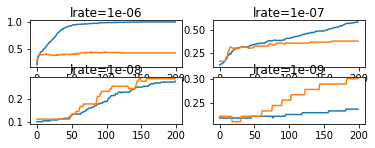

In [87]:
#-------------------------------LEARNING CURVE FOR NEURAL NETWORK ONLY-----------------------------------------------#
from keras.optimizers import Adam


def fit_model(trainX, trainy, testX, testy, lrate):
	# define model
	model = Sequential()
	model.add(Dense(120, input_dim=40000, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(6, activation='softmax'))
	# compile model
	opt = Adam(lr=lrate)
	model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
	history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1)
	# plot learning curves
	pyplot.plot(history.history['accuracy'], label='train')
	pyplot.plot(history.history['val_accuracy'], label='test')
	pyplot.title('lrate='+str(lrate), pad=-50)

# create learning curves for different learning rates
learning_rates = [1E-6, 1E-7,1E-8,1E-9]
for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model(X_train, y_train, X_test, y_test, learning_rates[i])
# show learning curves
pyplot.show()

In [109]:
#-------------------REGRESSION LOGISTIQUE WITH SCIKIT LEARN ---------------------
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=4)
logreg_cv.fit(X_train,y_train)
#score
best_parameters = logreg_cv.best_params_
best_accuracy = logreg_cv.best_score_
print(best_accuracy,best_parameters)


0.4074846356453029 {'C': 0.1, 'penalty': 'l2'}


In [107]:
#-------------------RANDOM FOREST WITH SCIKIT LEARN ---------------------

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)
#score
best_parameters = CV_rfc.best_params_
best_accuracy = CV_rfc.best_score_
print(best_accuracy,best_parameters)


0.5592592592592592 {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}


In [101]:
#-------------------SVM WITH SCIKIT LEARN ---------------------
from sklearn import svm
from sklearn.model_selection import cross_val_score

param_grid = {'C': [1e3, 1e5],
              'gamma': [0.0001, 0.1], }
clf = GridSearchCV(
    svm.SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train, y_train)
#score
best_parameters = clf.best_params_
best_accuracy = clf.best_score_
print(best_accuracy,best_parameters)
#scores = cross_val_score(clf, X_train, y_train, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# Use score method to get accuracy of model


0.5962962962962963 {'C': 1000.0, 'gamma': 0.0001}


**<ins>Question</ins>: Évaluer les modèles appris en décrivant votre méthode**

Pour chaques modèle on entraîne sur le jeu de donnée puis on test. 
Pour ce qui est des méthodes d'optimisation des hyper-paramètres, il y a deux méthodes:
-Learning/validation curve 
elle permet de voir l'évolution de la qualité du modèle en fonction de l'entraînement. 
Très utile pour detecter le surentraînement et autre spécificités du modèle.

-Grid search CV 
Permet de croiser tout les hyper-paramètres spécifiés et ressort le modèle avec les meilleurs hyper-paramètres.

# Pour le réseau de neurones:
J'ai utilisé les deux méthodes 
Le réseau permet d'obtenir une accuracy de 46% sur les données d'entraînement et de 43% sur les données de test.

# Regression logistique:
j'utilise Grid search CV 

hyper-paramètres: Learning rate

J'obtiens un score de 41%

# Random forest:
j'utilise Grid search CV 

hyper-paramètres: Profondeur de l'arbre, nombre d'arbres dans la forêt 

J'obtiens un score de 35%

# SVM:
j'utilise Grid search CV 

hyper-paramètres: C paramètre de régularisation, gamma 

J'obtiens un score de 71%

Le modèle SVM est donc le grand gagnant pour cette classification. 
Ce qui est prévisible car étant donné le jeu de données, c'est celui qui est recommandé par la SKlearn map que l'on peut retrouver sur l'API de la bibliothèque.

_Your code below_

**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)**

_Your image here_ <img src="fichierDiagramme.png" />

# Partie 2: Approche supervisée sur descripteurs issus du scattering operator

## Chargement des descripteurs

**<ins>Question</ins>: Chargez les données du fichier matlab imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat**

_Your Code below_

## Prétraitements

**<ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?**

_votre réponse ici:_ 

_Your Code below_

## Apprentissage

<strong><ins>Question</ins>: Séparer en deux ensembles de données et réalisez l'apprentissage successifs des modèles:
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

<span style='color:red'> **Pas de code à développer ici, réutiliser celui de la partie 1**</span>

_Your Code below_

## Fixer les hyper paramètres

**<ins>Question</ins>: Déterminez les hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment allez vous les fixer?**

_votre réponse ici:_

**<ins>Question</ins>:
Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html\#sphx-glr-auto-examples-applications-plot-face-recognition-py) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold).**

_Your Code below_

**<ins>Question</ins>: Évaluer les résultats et donner la valeur des paramètres optimaux**

_votre réponse ici:_

_Your Code below_

## Apprendre le modèle final pour chaque classifieur

_votre réponse ici:_

_Your Code below_

## Evaluer chaque classifieur

_votre réponse ici:_ 

_Your Code below_

## Partie 4 Analyse finale des résultats


**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation, les différents blocs de traitements.**

_votre réponse ici:_ 

_Your Code below_

**<ins>Question</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés et des prétraitements effectués.**

_votre réponse ici:_